# How to use NeXus/HDF5 Templates

Show how to use templates to write powder diffraction data using the NeXus
[NXmonopd](https://manual.nexusformat.org/classes/applications/NXmonopd.html#nxmonopd)
application definition.  Templates are used to:

- make links from existing fields or groups to new locations
- create new groups as directed
- create constants for attributes or fields

## Overview

This powder diffraction experiment positions a sample on a rotation stage (called
`th`, or $\theta$) and a detector at some distance on a second rotation axis
(called `tth`, or $2\theta$).  The experiment moves $2\theta$ through an
angular range while synchronizing $\theta$ to half of the $2\theta$
value.  The intensity of incident (`I0`) and scattered radiation (`sensor`) are
sampled at discrete angular intervals.  The `I0` detector is positioned before
the sample.  It does not move during the experiment.  The `sensor` detector is
mounted on a long arm projecting from the $2\theta$ rotation.

## Build the powder diffraction instrument

We simulate a powder diffraction instrument with a monochromatic source with a
Bluesky hardware setup similar to the
[guide](https://bcda-aps.github.io/apstools/latest/examples/fw_nxwriter.html) to
output scans(s) to a NeXus HDF5 file.  These are the modifications of that setup:

* Continue to use EPICS PVs for the simulation
* Change `motor` to `tth` ($2\theta$)
* Add `th` ($\theta$) motor
* Change sensor to a simulated Lorentzian
  * based on `tth` readback value
    * calculation will re-compute as motor position changes
  * center: randomly placed between 3 .. 8 degrees
  * width: random between 0.01 .. 0.51 degrees
  * height: random (~10,000)
* Add `I0` signal
  * Constant value: `100,000`

In [1]:
%matplotlib inline
import random
from apstools.synApps import setup_lorentzian_swait
from apstools.synApps import setup_random_number_swait
from apstools.synApps import SwaitRecord
from bluesky import RunEngine
from bluesky import plans as bp
from bluesky import plan_stubs as bps
from bluesky.callbacks.best_effort import BestEffortCallback
from matplotlib import pyplot as plt
from ophyd import EpicsMotor
from ophyd import EpicsSignalRO
from ophyd import Signal
import databroker

# bluesky-level
best_effort_callback = BestEffortCallback()
cat = databroker.temp().v2
plt.ion()  # enables matplotlib graphics
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(best_effort_callback)  # LivePlot & LiveTable

IOC = "gp:"

# ophyd-level
th = EpicsMotor(f"{IOC}m9", name="th")
tth = EpicsMotor(f"{IOC}m10", name="tth")
calc10 = SwaitRecord(f"{IOC}userCalc10", name="calc10")
I0 = Signal(name="I0", value=100_000)
sensor = EpicsSignalRO(calc10.calculated_value.pvname, name="sensor")

# set up calc10, updating at 10Hz
calc10.wait_for_connection()
tth.wait_for_connection()
setup_lorentzian_swait(
    calc10,
    tth.user_readback,
    center=3 + 5 * random.random(),
    width=0.01 + 0.5 * random.random(),
    scale=10_000 * (0.98 + 0.04 * random.random()),
    noise=0.02
)

# wait for the other connections
th.wait_for_connection()
sensor.wait_for_connection()

## Write data to a NeXus/HDF5 file

Use the `NXWriter()` from `apstools`.  Choose where to write the HDF5 file.

In [2]:
from apstools.callbacks import NXWriter
import json
import pathlib

h5_file = pathlib.Path("/tmp/nxwriter.h5")

nxwriter = NXWriter()
RE.subscribe(nxwriter.receiver)
nxwriter.file_name = str(h5_file)
nxwriter.warn_on_missing_content = False

## Use the NXmonopd application definition

Steps to configure the NXWriter to write raw data using the NeXus
[NXmonopd](https://manual.nexusformat.org/classes/applications/NXmonopd.html#nxmonopd)
powder diffraction application definition.

1. Review the definition.  Note what are the required groups and fields.
2. Write them as comments into a prototype of the template structure to be used.
3. Collect data from a $2\theta:\theta$ scan.
4. Examine the HDF5 file.
5. Create templates to connect existing data with NXmonopd definition.
6. Add constants and attributes as appropriate.
7. Collect data again with revised template and compare with the NXmonopd definition.

### Decisions when making the template.

To write data according to the *NXmonopd* definition, we must make some decisions
about linking to existing data and creating any new required structures.

First decision is where to write the structure of the application definition (
whether or not to use a
[NXsubentry](https://manual.nexusformat.org/classes/base_classes/NXsubentry.html#nxsubentry)
group).  The *NXsubentry* group is used for *multi-modal* experiments (such as
SAXS/WAXS).  Here, we are only writing raw monochromatic powder diffraction
data.  We do not need to use a *NXsubentry* group.  We will write the structure
into the NXentry group.

A NeXus file that uses an [application
definition](https://manual.nexusformat.org/classes/applications/index.html#application-definitions)
needs a `definition` field with the name of the application definition.  In this
case, the name is `"NXmonopd"`.  We write this with a *constant* template:

    ["/entry/definition=", "NXmonopd"]

The *NXmonopd* definition requires the *NXentry* group contain these fields: `title`
and `start_time`.  These fields are already provided by `NXWriter()`.  Nothing
more needs to be done.

*NXmonopd* requires a *NXcrystal* group with a `wavelength` field.  This is a
simulation, we can use any wavelength. It is convenient here to pass the
wavelength as run metadata.  (If it was available as an ophyd signal, it could
be recorded in the `baseline` stream.)  We'll call it `mono_wavelength` in the
metadata.  `NXWriter()` writes this metadata to the HDF5 address:
`/entry/instrument/bluesky/metadata/mono_wavelength`

The *NXcrystal* group is not created in the standard `NXWriter()`
file. We can create it and give it the name of `crystal` by using a *class
path*: `crystal:NXcrystal` which specifies both the group name and the NeXus
base class for the new group.  The next template connects the run metadata
`wavelength` with the location required by *NXmonopd* (note that the name of the
target field does not have to be the same as the source):

    [
        "/entry/instrument/bluesky/metadata/mono_wavelength",
        "/entry/instrument/crystal:NXcrystal/wavelength"
    ]

A *NXdetector* group is required with fields `polar_angle` and `data`.  These two
fields correspond to `tth` and `sensor`.  We use a class path for *NXdetector* in
case the group does not already exist.  These templates provide the links:

    [
        "/entry/instrument/bluesky/streams/primary/tth/value",
        "/entry/instrument/detector:NXdetector/polar_angle"
    ],
    [
        "/entry/instrument/bluesky/streams/primary/sensor/value",
        "/entry/instrument/detector:NXdetector/data"
    ],

A sample name is required in a *NXsample* group.  We'll give the sample name in
the metadata, then link it with a template:

    [
        "/entry/instrument/bluesky/metadata/sample_name",
        "/entry/instrument/sample:NXsample/name"
    ]

The *NXmonopd* definition is unclear whether or not a `rotation_angle` field is
required.  The text says it is optional but the presence of `"(required)"` means
it must be provided.  We'll set it to a constant of zero:

    ["/entry/sample:NXsample/rotation_angle=", 0],

A *NXmonitor* group is required with fields `mode`, `preset`, and `integral`.
This simulation uses a constant monitor count (`I0`), not a counting time.  The
`preset` field is the number of counts required for `I0` at each collection.
These are the templates for the *NXmonitor* group:

    ["/entry/monitor:NXmonitor/mode=", "monitor"],
    ["/entry/monitor:NXmonitor/preset=", I0.get()],
    [
        "/entry/instrument/bluesky/streams/primary/I0/value",
        "/entry/monitor:NXmonitor/integral"
    ],

The NeXus NXmonitor group acts like a *NXdata* group.  We add a
`@signal="integral"` attribute that names `integral` as the default field in
that group to be plotted.  This is not required but is of great assistance when
using visualization software such as [NeXPy](https://nexpy.github.io/nexpy/).

    ["/entry/monitor:NXmonitor/@signal", "integral"],

The *NXmonopd* definition specifies a `DATA:NXdata` group.  The `NXWriter()`
creates a `data:NXdata` group and links all the detector and motor fields into
this group.  Since *NXmonopd* requres some different names, we choose to create
an additional *NXdata* group.  In a NeXus definition, a field name that is given
in all upper case, such as `DATA` means that the name can be chosen by us.
We'll use `monopd` as this group's name.  The `@signal` attribute names the
ordinate ($y$) axis to be plotted, the `@axes` attribute names any abcissae
($x$).  In this case, we only use $2\theta$ (mapped to `polar_angle`) as the $x$
axis, as customary for powder diffraction data.

    ["/entry/instrument/bluesky/streams/primary/tth/value", "/entry/monopd:NXdata/polar_angle"],
    ["/entry/instrument/bluesky/streams/primary/sensor/value", "/entry/monopd:NXdata/data"],
    ["/entry/monopd/@signal", "data"],
    ["/entry/monopd/@axes", ["polar_angle", ]],

Finally, we change the default data group to point to our new `monopd` group:

    ["/entry/@default", "monopd"],

In [3]:
templates = [
    ["/entry/definition=", "NXmonopd"],  # satisfy the NXmonopd definnition
    # /entry/title  already defined
    # /entry/start_time  already defined
    # /entry/instrument/source/type  already defined
    # /entry/instrument/source/name  already defined
    # /entry/instrument/source/probe  already defined
    ["/entry/instrument/bluesky/metadata/mono_wavelength", "/entry/instrument/crystal:NXcrystal/wavelength"],
    ["/entry/instrument/bluesky/streams/primary/tth/value", "/entry/instrument/detector:NXdetector/polar_angle"],
    ["/entry/instrument/bluesky/streams/primary/sensor/value", "/entry/instrument/detector:NXdetector/data"],
    ["/entry/instrument/bluesky/metadata/sample_name", "/entry/sample:NXsample/name"],
    ["/entry/sample:NXsample/rotation_angle=", 0],  # sample has not been rotated
    ["/entry/monitor:NXmonitor/mode=", "monitor"],  # in this simulation
    ["/entry/monitor:NXmonitor/preset=", I0.get()],  # constant
    ["/entry/instrument/bluesky/streams/primary/I0/value", "/entry/monitor:NXmonitor/integral"],
    ["/entry/instrument/bluesky/streams/primary/tth/value", "/entry/monopd:NXdata/polar_angle"],
    ["/entry/instrument/bluesky/streams/primary/sensor/value", "/entry/monopd:NXdata/data"],
    ["/entry/monopd/@signal", "data"],
    ["/entry/monopd/@axes", ["polar_angle", ]],
    ["/entry/@default", "monopd"],  # change the default plot group
    ["/entry/monitor:NXmonitor/@signal", "integral"],  # in NXmonitor, same as for NXdata groups
]

In [4]:
md = {
    "title": "Demonstrate NeXus/HDF5 template support", 
    nxwriter.template_key: json.dumps(templates),
    "mono_wavelength": 1.0,  # simulation
    "sample_name": "simulation",
}

## Run a $2\theta:\theta$ scan

1. Make a bluesky plan
2. Run the plan with the `RE`, stepping `tth` across the range where the
   Lorentzian peak is expected.
   1. Print a table of the data as it is measured.
   2. Plot the `sensor` and `I0` signals, separately.
3. Verify the NeXus/HDF5 file has been saved.



Transient Scan ID: 1     Time: 2023-12-02 13:15:51
Persistent Unique Scan ID: '90acae1f-2475-406a-b86f-05b7ca2bb7d2'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time |        tth |         th |     sensor |         I0 |
+-----------+------------+------------+------------+------------+------------+
|         1 | 13:15:51.7 |     2.0000 |     1.0000 |    0.00000 |     100000 |
|         2 | 13:15:52.8 |     2.8000 |     1.4000 |  182.83233 |     100000 |
|         3 | 13:15:53.9 |     3.6000 |     1.8000 |  390.07416 |     100000 |
|         4 | 13:15:55.0 |     4.4000 |     2.2000 | 1233.82536 |     100000 |
|         5 | 13:15:56.1 |     5.2000 |     2.6000 | 8820.36874 |     100000 |
|         6 | 13:15:57.3 |     6.0000 |     3.0000 | 1987.91262 |     100000 |
|         7 | 13:15:58.5 |     6.8000 |     3.4000 |  503.62617 |     100000 |
|         8 | 13:15:59.8 |     7.6000 |     3.8000 |  222.62671 |    

('90acae1f-2475-406a-b86f-05b7ca2bb7d2',)

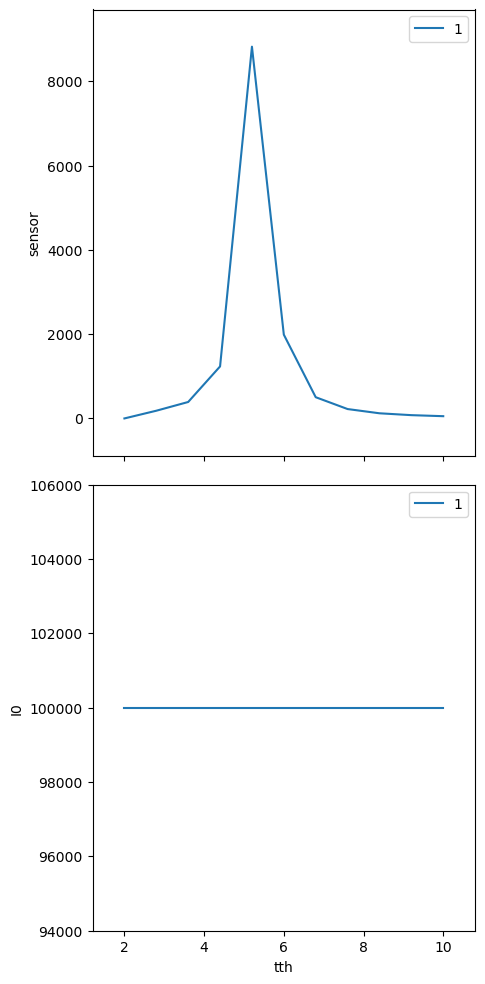

In [5]:
def th2th(detectors, tth, th, start, finish, num, md={}):
    # Since x2x is a relative scan, first move to the absolute start positions.
    yield from bps.mv(tth, start, th, start/2)
    yield from bp.x2x_scan(detectors, tth, th, 0, finish-start, num, md=md)
    print(f"{h5_file.exists()=}  {h5_file=}")

RE(th2th([sensor, I0], tth, th, 2, 10, 11, md=md))

## Look at the NeXus/HDF5 *NXmonopd* file

In [6]:
from apstools.utils import unix

for line in unix(f"punx tree {nxwriter.file_name}"):
    print(line.decode().strip())

!!! WARNING: this program is not ready for distribution.

/tmp/nxwriter.h5 : NeXus data file
  @HDF5_Version = "1.14.0"
  @NeXus_release = "v2020.1"
  @creator = "NXWriter"
  @default = "entry"
  @file_name = "/tmp/nxwriter.h5"
  @file_time = "2023-12-02T13:16:03.536788"
  @h5py_version = "3.9.0"
  entry:NXentry
    @NX_class = "NXentry"
    @default = "monopd"
    @target = "/entry"
    definition:NX_CHAR = b'NXmonopd'
      @target = "/entry/definition"
    duration:NX_FLOAT64[] = 
      @units = "s"
    end_time:NX_CHAR = b'2023-12-02T13:16:03.365098'
    entry_identifier --> /entry/instrument/bluesky/metadata/run_start_uid
    plan_name --> /entry/instrument/bluesky/metadata/plan_name
    program_name:NX_CHAR = b'bluesky'
    start_time:NX_CHAR = b'2023-12-02T13:15:51.630091'
    title:NX_CHAR = b'x2x_scan-S0001-90acae1'
    data:NXdata
      @NX_class = "NXdata"
      @axes = ["tth", "th"]
      @signal = "sensor"
      @target = "/entry/data"
      EPOCH --> /entry/instrument/blu